<a href="https://colab.research.google.com/github/white9812/notimportant_ai/blob/main/0729_%EA%B0%95%EC%9B%90%EB%8F%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os

In [ ]:


from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#합쳐진 데이터셋 불러오기
concat_csv=os.listdir("/content/drive/MyDrive/filled_data")
concat_csv=concat_csv[:-1]

In [ ]:

concat_Df=[]
for concat_csv_path in concat_csv:


    path="/content/drive/MyDrive/filled_data/"
    c_df=pd.read_csv(path+f"{concat_csv_path}") #station의 데이터 이름에 데이터 프레임 저장하기
    concat_Df.append(c_df)



In [ ]:
concat_csv

['강원도.csv',
 '경상남도.csv',
 '경기도.csv',
 '광주시.csv',
 '경상북도.csv',
 '대구시.csv',
 '강원도filled_data.csv']

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

from tqdm import tqdm


In [ ]:
concat_Df[0].columns

Index(['시간', '지점명', 'Solar_Power(MWh)', '일사', '일조', '습도', '지면온도', '시정', '기온',
       '중하층운량', '풍속', '전운량', '강수량', '해면기압', '풍향', '적설', '현지기압', '증기압', '최저운고',
       '이슬점온도'],
      dtype='object')

In [ ]:
corr_data=concat_Df[0][[ 'Solar_Power(MWh)', '일사', '일조', '습도', '지면온도', '시정', '기온',
       '중하층운량', '풍속', '전운량', '강수량', '해면기압', '풍향', '적설', '현지기압', '증기압', '최저운고',
       '이슬점온도']].corr()

In [ ]:
df_imputed_corr=round(corr_data.abs(),2)
correlations_solar_power =df_imputed_corr.loc[:, "Solar_Power(MWh)"]
high_correlations = correlations_solar_power[correlations_solar_power >= 0.2]

In [ ]:
corr_list=high_correlations.index.to_list()

In [ ]:
sampledata=concat_Df[0][corr_list].copy()

In [ ]:
sampledata.isna().sum()

Solar_Power(MWh)        0
일사                      0
일조                      0
습도                     12
지면온도                   15
시정                    260
기온                     12
중하층운량               13989
풍속                     29
dtype: int64

In [ ]:
# Custom IterativeImputer to show progress
class IterativeImputerWithProgress(IterativeImputer):
    def __init__(self, estimator=None, missing_values=np.nan, sample_posterior=False, max_iter=30,
                 tol=1e-3, n_nearest_features=None, initial_strategy="mean", imputation_order='ascending',
                 skip_complete=False, min_value=None, max_value=None, verbose=0, random_state=None, add_indicator=False):
        super().__init__(estimator=estimator, missing_values=missing_values, sample_posterior=sample_posterior,
                         max_iter=max_iter, tol=tol, n_nearest_features=n_nearest_features, initial_strategy=initial_strategy,
                         imputation_order=imputation_order, skip_complete=skip_complete, min_value=min_value,
                         max_value=max_value, verbose=verbose, random_state=random_state, add_indicator=add_indicator)
        self._tqdm = None

    def fit_transform(self, X, y=None):
        self._tqdm = tqdm(total=self.max_iter, desc='Imputation Progress')
        result = super().fit_transform(X, y)
        self._tqdm.close()
        return result

    def _impute_one_feature(self, X_filled, mask_missing_values, feat_idx, neighbor_feat_idx, estimator=None, fit_mode=True):
        imputed_values = super()._impute_one_feature(X_filled, mask_missing_values, feat_idx, neighbor_feat_idx, estimator, fit_mode)
        if fit_mode:
            self._tqdm.update(1)
        return imputed_values

# RandomForestRegressor 설정 조정
reduced_rf = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=0)

# 배치 크기 설정
batch_size = len(sampledata)

# 배치별로 MissForest 알고리즘 적용
imputed_batches = []
n_batches = int(np.ceil(len(sampledata) / batch_size))

for i in range(n_batches):
    batch = sampledata.iloc[i * batch_size:(i + 1) * batch_size]
    imputer = IterativeImputerWithProgress(estimator=reduced_rf, max_iter=30, random_state=0, add_indicator=False)
    imputed_batch = imputer.fit_transform(batch)
    # 반환된 imputed_batch의 형태 확인
    print(f"Batch {i+1} shape: {imputed_batch.shape}")

    # 데이터프레임으로 변환
    imputed_batch_df = pd.DataFrame(imputed_batch, columns=sampledata.columns[:imputed_batch.shape[1]])
    imputed_batches.append(imputed_batch_df)



# 배치 결합
df_imputed = pd.concat(imputed_batches, axis=0).reset_index(drop=True)
df_imputed.to_csv("강원도_0729_filled.csv",index=False)


Imputation Progress: 270it [34:53,  7.44s/it]/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
Imputation Progress: 270it [34:53,  7.75s/it]


Batch 1 shape: (53999, 9)


In [ ]:
df_imputed.to_csv("강원도_0729_3_45_filled.csv",index=False)

In [ ]:
df_imputed.isna().sum() # missforest 적용 후

Solar_Power(MWh)    0
일사                  0
일조                  0
습도                  0
지면온도                0
시정                  0
기온                  0
중하층운량               0
풍속                  0
dtype: int64

In [ ]:
sampledata.isna().sum() # missforest 적용 전

Solar_Power(MWh)        0
일사                      0
일조                      0
습도                     12
지면온도                   15
시정                    260
기온                     12
중하층운량               13989
풍속                     29
dtype: int64

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split


In [ ]:
pip install pandas numpy matplotlib scikit-learn tensorflow


In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
concat_Df[0]["시간"]

0        2017-01-01 01:00:00
1        2017-01-01 02:00:00
2        2017-01-01 03:00:00
3        2017-01-01 04:00:00
4        2017-01-01 05:00:00
                ...         
53994    2023-02-28 19:00:00
53995    2023-02-28 20:00:00
53996    2023-02-28 21:00:00
53997    2023-02-28 22:00:00
53998    2023-02-28 23:00:00
Name: 시간, Length: 53999, dtype: object

In [ ]:
df_imputed["시간"]=concat_Df[0]["시간"]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
scaler = RobustScaler()
data_scaled = scaler.fit_transform(df_imputed[['일사', '일조']])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

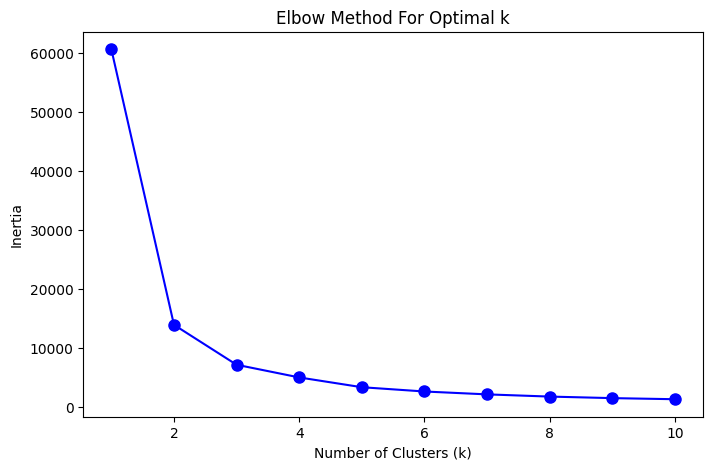

In [ ]:
# 클러스터 수를 달리하면서 KMeans 적용 및 Inertia 계산
inertia_values = []
K = range(1, 11)  # 1부터 10까지 클러스터 수에 대해 테스트

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia_values.append(kmeans.inertia_)

# Inertia 값 시각화
plt.figure(figsize=(8, 5))
plt.plot(K, inertia_values, 'bo-', markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
# 최적의 군집 수 설정 (엘보우 그래프 참고)
optimal_clusters = 4

# KMeans 클러스터링


kmeans = KMeans(n_clusters=optimal_clusters, random_state=42).fit(data_scaled)
df_imputed['Cluster'] = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
from lightgbm import LGBMRegressor

Imputation Progress:   0%|          | 0/10 [15:18<?, ?it/s]
/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
from sklearn.model_selection import  GridSearchCV

In [ ]:
# GridSearchCV를 사용하여 하이퍼파라미터 튜닝
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 100],
    'feature_fraction': [0.8, 0.9, 1.0],
    'bagging_fraction': [0.8, 0.9, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5],
    'reg_lambda': [0.0, 0.1, 0.5]
}

In [ ]:
data=df_imputed.copy()

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1453
[LightGBM] [Info] Number of data points in the train set: 5760, number of used features: 12
[LightGBM] [Info] Start training from score 0.190391


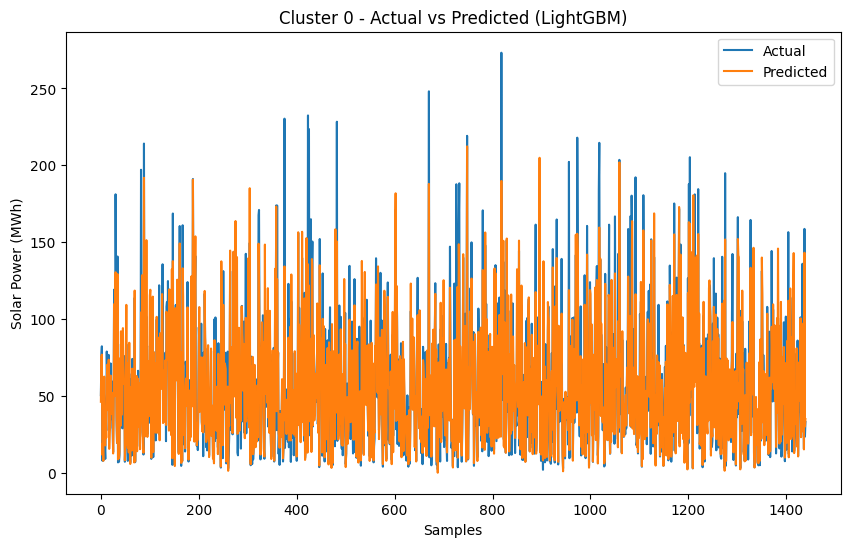

Epoch 1/100
180/180 [==============================] - 12s 23ms/step - loss: 0.8199 - val_loss: 0.4674 - lr: 0.0010
Epoch 2/100
180/180 [==============================] - 2s 11ms/step - loss: 0.4936 - val_loss: 0.3133 - lr: 0.0010
Epoch 3/100
180/180 [==============================] - 2s 11ms/step - loss: 0.3906 - val_loss: 0.2656 - lr: 0.0010
Epoch 4/100
180/180 [==============================] - 2s 11ms/step - loss: 0.3324 - val_loss: 0.2483 - lr: 0.0010
Epoch 5/100
180/180 [==============================] - 2s 11ms/step - loss: 0.3113 - val_loss: 0.2442 - lr: 0.0010
Epoch 6/100
180/180 [==============================] - 2s 13ms/step - loss: 0.2940 - val_loss: 0.2438 - lr: 0.0010
Epoch 7/100
180/180 [==============================] - 3s 16ms/step - loss: 0.2778 - val_loss: 0.2389 - lr: 0.0010
Epoch 8/100
180/180 [==============================] - 2s 13ms/step - loss: 0.2744 - val_loss: 0.2367 - lr: 0.0010
Epoch 9/100
180/180 [==============================] - 2s 11ms/step - loss: 0.2

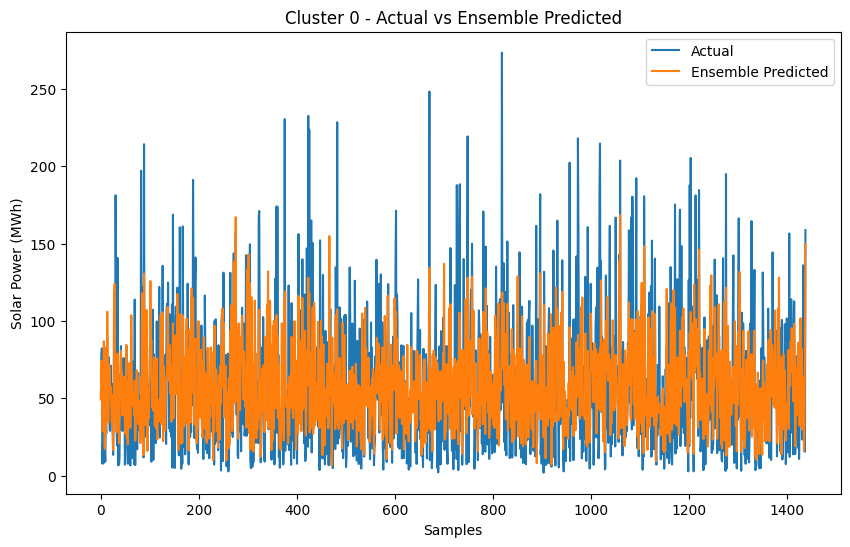

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1422
[LightGBM] [Info] Number of data points in the train set: 5484, number of used features: 12
[LightGBM] [Info] Start training from score 0.127351


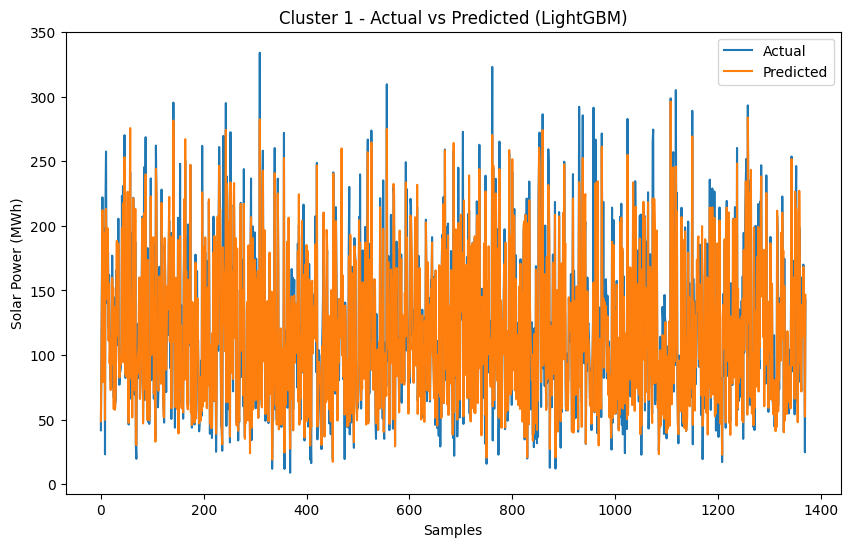

Epoch 1/100
172/172 [==============================] - 10s 24ms/step - loss: 0.6071 - val_loss: 0.3003 - lr: 0.0010
Epoch 2/100
172/172 [==============================] - 3s 16ms/step - loss: 0.3222 - val_loss: 0.1661 - lr: 0.0010
Epoch 3/100
172/172 [==============================] - 2s 11ms/step - loss: 0.2224 - val_loss: 0.1466 - lr: 0.0010
Epoch 4/100
172/172 [==============================] - 2s 11ms/step - loss: 0.1802 - val_loss: 0.1284 - lr: 0.0010
Epoch 5/100
172/172 [==============================] - 2s 11ms/step - loss: 0.1532 - val_loss: 0.1187 - lr: 0.0010
Epoch 6/100
172/172 [==============================] - 2s 11ms/step - loss: 0.1478 - val_loss: 0.1203 - lr: 0.0010
Epoch 7/100
172/172 [==============================] - 2s 11ms/step - loss: 0.1382 - val_loss: 0.1145 - lr: 0.0010
Epoch 8/100
172/172 [==============================] - 3s 15ms/step - loss: 0.1319 - val_loss: 0.1148 - lr: 0.0010
Epoch 9/100
172/172 [==============================] - 3s 17ms/step - loss: 0.1

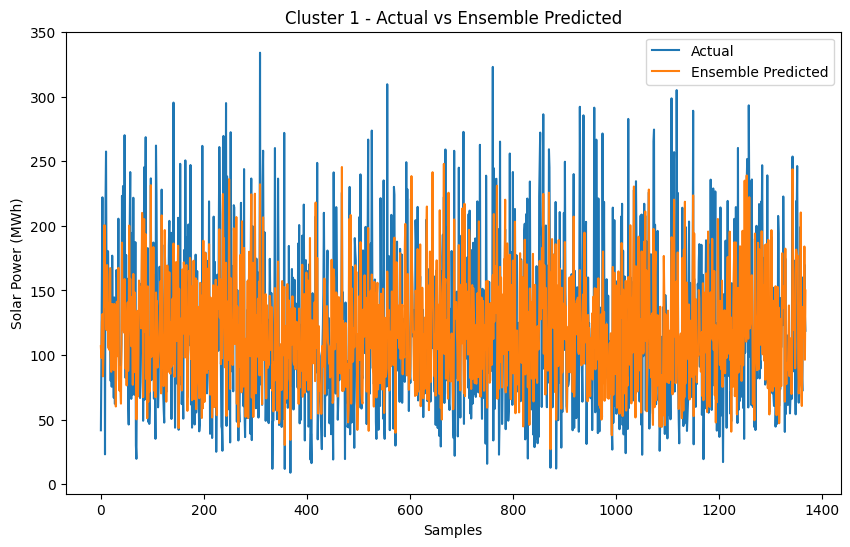

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1411
[LightGBM] [Info] Number of data points in the train set: 28575, number of used features: 12
[LightGBM] [Info] Start training from score 0.725240


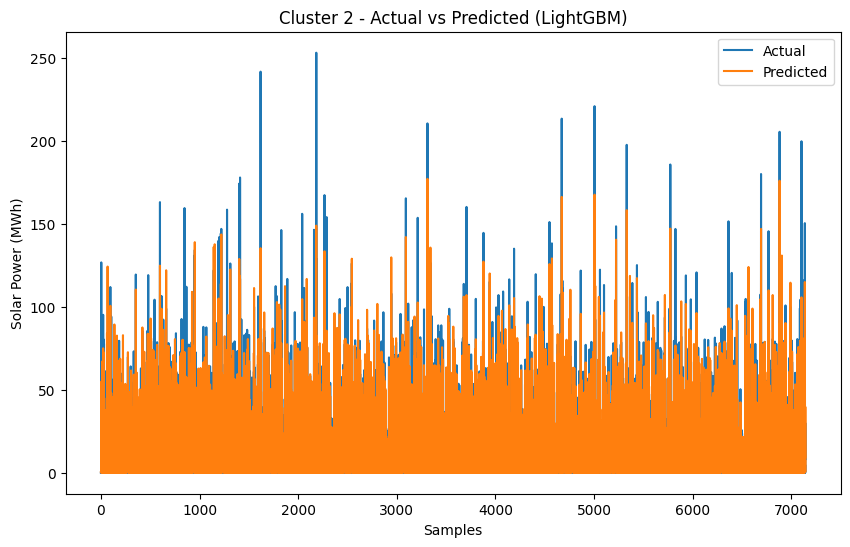

Epoch 1/100
893/893 [==============================] - 21s 14ms/step - loss: 1.0114 - val_loss: 0.5688 - lr: 0.0010
Epoch 2/100
893/893 [==============================] - 11s 12ms/step - loss: 0.6468 - val_loss: 0.5527 - lr: 0.0010
Epoch 3/100
893/893 [==============================] - 12s 13ms/step - loss: 0.5905 - val_loss: 0.5190 - lr: 0.0010
Epoch 4/100
893/893 [==============================] - 12s 13ms/step - loss: 0.5811 - val_loss: 0.5238 - lr: 0.0010
Epoch 5/100
893/893 [==============================] - 10s 11ms/step - loss: 0.5576 - val_loss: 0.4999 - lr: 0.0010
Epoch 6/100
893/893 [==============================] - 12s 13ms/step - loss: 0.5448 - val_loss: 0.4810 - lr: 0.0010
Epoch 7/100
893/893 [==============================] - 12s 13ms/step - loss: 0.5266 - val_loss: 0.4716 - lr: 0.0010
Epoch 8/100
893/893 [==============================] - 10s 12ms/step - loss: 0.5234 - val_loss: 0.4764 - lr: 0.0010
Epoch 9/100
893/893 [==============================] - 11s 13ms/step - l

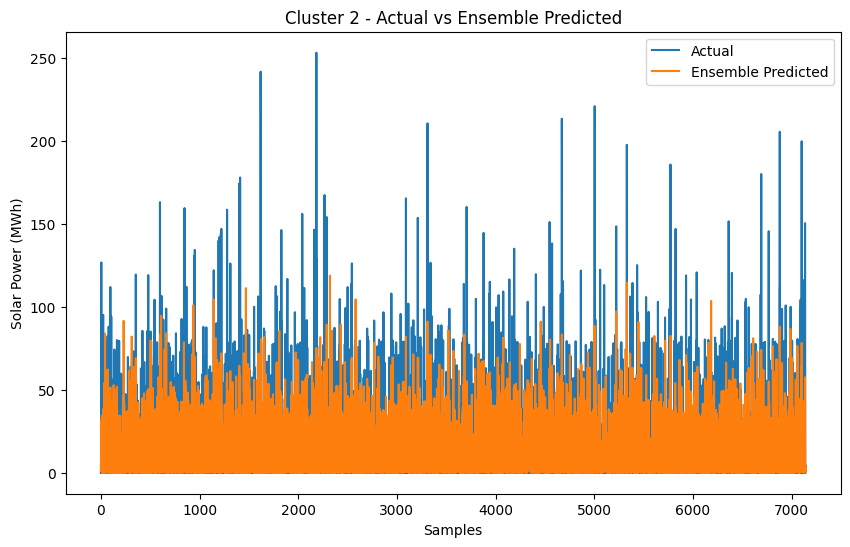

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1405
[LightGBM] [Info] Number of data points in the train set: 3380, number of used features: 12
[LightGBM] [Info] Start training from score 0.153647


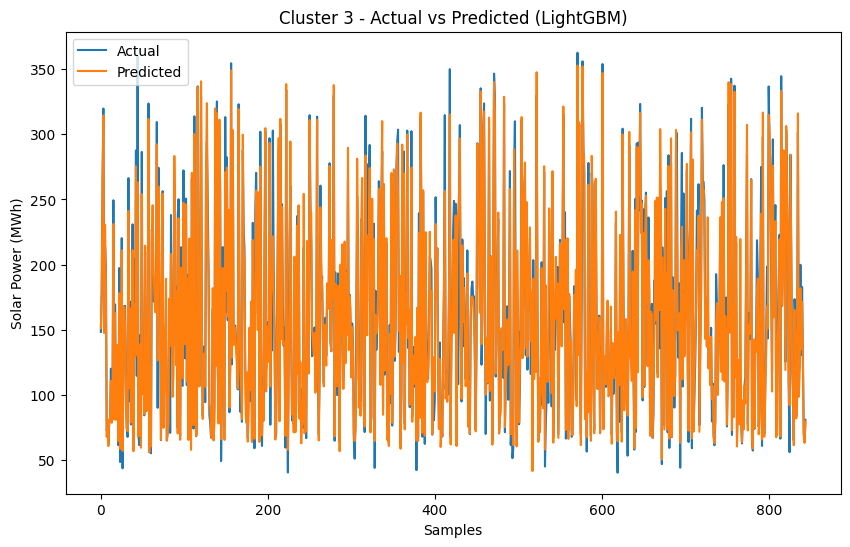

Epoch 1/100
106/106 [==============================] - 10s 24ms/step - loss: 0.9134 - val_loss: 0.2966 - lr: 0.0010
Epoch 2/100
106/106 [==============================] - 1s 12ms/step - loss: 0.4839 - val_loss: 0.1916 - lr: 0.0010
Epoch 3/100
106/106 [==============================] - 1s 12ms/step - loss: 0.3317 - val_loss: 0.1459 - lr: 0.0010
Epoch 4/100
106/106 [==============================] - 1s 14ms/step - loss: 0.2338 - val_loss: 0.0871 - lr: 0.0010
Epoch 5/100
106/106 [==============================] - 2s 16ms/step - loss: 0.1880 - val_loss: 0.0621 - lr: 0.0010
Epoch 6/100
106/106 [==============================] - 2s 16ms/step - loss: 0.1413 - val_loss: 0.0617 - lr: 0.0010
Epoch 7/100
106/106 [==============================] - 2s 16ms/step - loss: 0.1215 - val_loss: 0.0568 - lr: 0.0010
Epoch 8/100
106/106 [==============================] - 2s 16ms/step - loss: 0.1001 - val_loss: 0.0523 - lr: 0.0010
Epoch 9/100
106/106 [==============================] - 1s 12ms/step - loss: 0.0

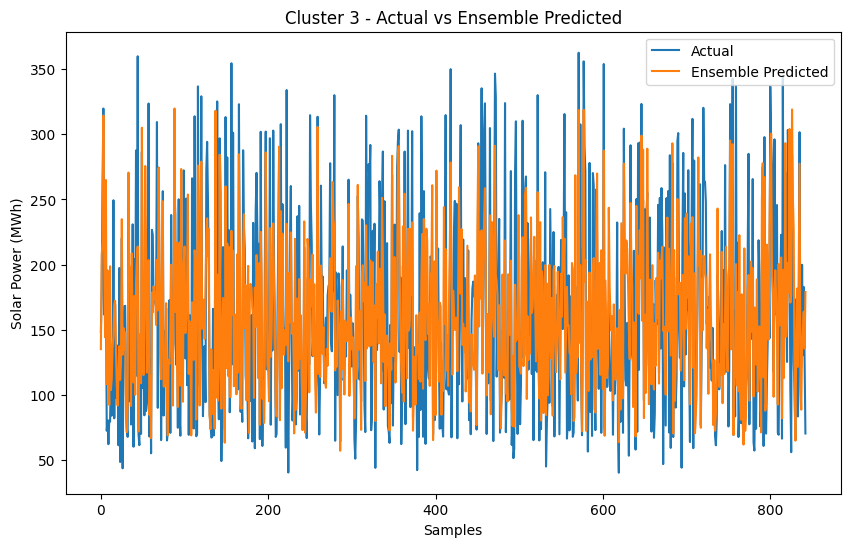

RMSE scores: [17.559873481766672, 18.609497833050415, 8.585112497212169, 19.084670628075514]
MAE scores: [10.85757527945411, 13.022072207396254, 3.734138055685048, 11.699145592326042]
Average RMSE: 15.959788610026191
Average MAE: 9.828232783715364


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt

# Sample parameter grid for RandomizedSearchCV
param_grid = {
    'num_leaves': [31, 50, 70],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500]
}

rmse_scores = []
mae_scores = []
original_bound = []
original_describe = []
mape_scores = []
smape_scores = []


def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Assuming 'data' is already loaded and preprocessed
data['시간'] = pd.to_datetime(data['시간'])
data['year'] = data['시간'].dt.year
data['month'] = data['시간'].dt.month
data['day'] = data['시간'].dt.day
data['hour'] = data['시간'].dt.hour

# 필요한 데이터 컬럼 선택
time_features = ['year', 'month', 'day', 'hour']
target_feature = 'Solar_Power(MWh)'

for cluster in np.unique(data['Cluster']):
    cluster_data = data[data['Cluster'] == cluster].reset_index(drop=True)

    # LightGBM 모델
    X_lightgbm = cluster_data.drop(columns=['Solar_Power(MWh)', '시간'])
    y_lightgbm = cluster_data['Solar_Power(MWh)'].values.reshape(-1, 1)

    scaler_X = RobustScaler()
    scaler_y = RobustScaler()

    X_lightgbm_scaled = scaler_X.fit_transform(X_lightgbm)
    y_lightgbm_scaled = scaler_y.fit_transform(y_lightgbm)

    X_train_lgb, X_test_lgb, y_train_lgb, y_test_lgb = train_test_split(X_lightgbm_scaled, y_lightgbm_scaled, test_size=0.2, random_state=42)

    model = LGBMRegressor(random_state=42)

    # RandomizedSearchCV를 사용하여 하이퍼파라미터 튜닝
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1, random_state=42)

    random_search.fit(X_train_lgb, y_train_lgb.ravel())

    best_model = random_search.best_estimator_
    # 예측
    y_pred_lgb = best_model.predict(X_test_lgb)


    # 예측값을 원래 스케일로 복원
    y_test_orig = scaler_y.inverse_transform(y_test_lgb)
    # 원래 스케일로 복원
    y_pred_lgb_original = scaler_y.inverse_transform(y_pred_lgb.reshape(-1, 1))

    # 0 미만의 예측 값을 0으로 처리
    y_pred_lgb_original = np.maximum(0, y_pred_lgb_original)

    # 원래 스케일로 복원된 y_test도 필요
    y_test_lgb_original = scaler_y.inverse_transform(y_test_lgb)
    y_test_df = pd.DataFrame(y_test_orig)

    bound = (y_test_orig.min(), y_test_orig.max())
    original_bound.append(bound)
    original_describe.append(y_test_df.describe())

    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_lgb_original))
    mae = mean_absolute_error(y_test_orig,y_pred_lgb_original)

    rmse_scores.append(rmse)
    mae_scores.append(mae)

    plt.figure(figsize=(10, 6))
    plt.plot(y_test_orig, label='Actual')
    plt.plot(y_pred_lgb_original, label='Predicted')
    plt.title(f'Cluster {cluster} - Actual vs Predicted (LightGBM)')
    plt.xlabel('Samples')
    plt.ylabel('Solar Power (MWh)')
    plt.legend()
    plt.show()

    # LSTM 모델
    X_lstm = cluster_data[time_features + list(X_lightgbm.columns)]
    y_lstm = cluster_data['Solar_Power(MWh)'].values.reshape(-1, 1)

    X_lstm_scaled = scaler_X.fit_transform(X_lstm)
    y_lstm_scaled = scaler_y.fit_transform(y_lstm)

    time_steps = 10
    X_lstm_seq, y_lstm_seq = create_sequences(X_lstm_scaled, y_lstm_scaled, time_steps)

    X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm_seq, y_lstm_seq, test_size=0.2, random_state=42)

    def lr_schedule(epoch, lr):
        if epoch < 10:
            return lr
        else:
            return lr * np.exp(-0.1)

    lstm_model = Sequential()
    lstm_model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(time_steps, X_lstm_seq.shape[2])))
    lstm_model.add(BatchNormalization())
    lstm_model.add(Dropout(0.2))
    lstm_model.add(Bidirectional(LSTM(50)))
    lstm_model.add(BatchNormalization())
    lstm_model.add(Dropout(0.2))
    lstm_model.add(Dense(1))

    lstm_model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_scheduler = LearningRateScheduler(lr_schedule)

    lstm_model.fit(X_train_lstm, y_train_lstm, epochs=100, batch_size=32, validation_data=(X_test_lstm, y_test_lstm), callbacks=[early_stopping, lr_scheduler], verbose=1)

    y_pred_lstm = lstm_model.predict(X_test_lstm)

    # LSTM 예측값을 원래 스케일로 복원
    y_pred_lstm_orig = scaler_y.inverse_transform(y_pred_lstm)

    # 0 미만의 예측 값을 0으로 처리
    y_pred_lstm_orig = np.maximum(0, y_pred_lstm_orig)


    # 앙상블 예측
    min_len = min(len(y_pred_lstm_orig), len(y_pred_lgb_original))
    y_pred_lstm_orig = y_pred_lstm_orig[:min_len]
    y_pred_lgb_original = y_pred_lgb_original[:min_len]


    y_pred_ensemble = (y_pred_lstm_orig.flatten() + y_pred_lgb_original.flatten()) / 2

    y_test_lgb = y_test_orig[:min_len]

    rmse = np.sqrt(mean_squared_error(y_test_lgb, y_pred_ensemble))
    mae = mean_absolute_error(y_test_lgb, y_pred_ensemble)
    # MAPE와 sMAPE 계산
    mape = np.mean(np.abs((y_test_orig - y_pred_lgb_original) / y_test_orig)) * 100
    smape = np.mean(2.0 * np.abs(y_test_orig - y_pred_lgb_original) / (np.abs(y_test_orig) + np.abs(y_pred_lgb_original))) * 100

    rmse_scores.append(rmse)
    mae_scores.append(mae)
    mape_scores.append(mape)
    smape_scores.append(smape)


    print(f"Cluster {cluster} - Ensemble RMSE:", rmse)
    print(f"Cluster {cluster} - Ensemble MAE:", mae)

    plt.figure(figsize=(10, 6))
    plt.plot(y_test_lgb, label='Actual')
    plt.plot(y_pred_ensemble, label='Ensemble Predicted')
    plt.title(f'Cluster {cluster} - Actual vs Ensemble Predicted')
    plt.xlabel('Samples')
    plt.ylabel('Solar Power (MWh)')
    plt.legend()
    plt.show()

print("RMSE scores:", rmse_scores)
print("MAE scores:", mae_scores)
print("Average RMSE:", np.mean(rmse_scores))
print("Average MAE:", np.mean(mae_scores))


#### LightGBM만 적용

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from lightgbm import LGBMRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt

# Define Huber loss function
def huber_approx_obj(preds, dtrain, delta=1.0):
    d = preds - dtrain.get_label()
    h = delta * (np.sqrt(1 + (d / delta)**2) - 1)
    grad = d / np.sqrt(1 + (d / delta)**2)
    hess = 1 / np.sqrt(1 + (d / delta)**2)
    return grad, hess

# Sample parameter grid for RandomizedSearchCV
param_grid = {
    'num_leaves': [31, 50, 70],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500]
}

rmse_scores = []
mae_scores = []
mape_scores = []
smape_scores = []

# Assuming 'data' is already loaded and preprocessed
data['시간'] = pd.to_datetime(data['시간'])
data['year'] = data['시간'].dt.year
data['month'] = data['시간'].dt.month
data['day'] = data['시간'].dt.day
data['hour'] = data['시간'].dt.hour

# 필요한 데이터 컬럼 선택
time_features = ['year', 'month', 'day', 'hour']
target_feature = 'Solar_Power(MWh)'

for cluster in np.unique(data['Cluster']):
    cluster_data = data[data['Cluster'] == cluster].reset_index(drop=True)

    # LightGBM 모델
    X_lightgbm = cluster_data.drop(columns=['Solar_Power(MWh)', '시간'])
    y_lightgbm = cluster_data['Solar_Power(MWh)'].values.reshape(-1, 1)

    scaler_X = RobustScaler()
    scaler_y = RobustScaler()

    X_lightgbm_scaled = scaler_X.fit_transform(X_lightgbm)
    y_lightgbm_scaled = scaler_y.fit_transform(y_lightgbm)

    X_train_lgb, X_test_lgb, y_train_lgb, y_test_lgb = train_test_split(X_lightgbm_scaled, y_lightgbm_scaled, test_size=0.2, random_state=42)

    train_data = lgb.Dataset(X_train_lgb, label=y_train_lgb.ravel())
    valid_data = lgb.Dataset(X_test_lgb, label=y_test_lgb.ravel(), reference=train_data)

    params = {
        'objective': 'regression',
        'metric': 'l2',
        'learning_rate': 0.05,
        'num_leaves': 31,
        'min_data_in_leaf': 20,
        'lambda_l1': 0.1,
        'lambda_l2': 0.1,
        'verbose': -1,
        'boosting_type': 'gbdt'
    }

    model = lgb.train(params, train_data, valid_sets=[valid_data], num_boost_round=200, early_stopping_rounds=10, fobj=huber_approx_obj)

    y_pred_lgb = model.predict(X_test_lgb, num_iteration=model.best_iteration)

    # 예측값을 원래 스케일로 복원
    y_pred_lgb_original = scaler_y.inverse_transform(y_pred_lgb.reshape(-1, 1))
    y_test_orig = scaler_y.inverse_transform(y_test_lgb)

    # 0 미만의 예측 값을 0으로 처리
    y_pred_lgb_original = np.maximum(0, y_pred_lgb_original)

    # 실제 값이 0인 경우 작은 값으로 대체
    y_test_orig_replaced = np.where(y_test_orig == 0, 1e-10, y_test_orig)
    y_pred_lgb_original_replaced = np.where(y_pred_lgb_original == 0, 1e-10, y_pred_lgb_original)

    # 성능 평가
    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_lgb_original))
    mae = mean_absolute_error(y_test_orig, y_pred_lgb_original)

    # MAPE와 sMAPE 계산
    mape = np.mean(np.abs((y_test_orig_replaced - y_pred_lgb_original_replaced) / y_test_orig_replaced)) * 100
    smape = np.mean(2.0 * np.abs(y_test_orig_replaced - y_pred_lgb_original_replaced) / (np.abs(y_test_orig_replaced) + np.abs(y_pred_lgb_original_replaced))) * 100

    rmse_scores.append(rmse)
    mae_scores.append(mae)
    mape_scores.append(mape)
    smape_scores.append(smape)

    plt.figure(figsize=(10, 6))
    plt.plot(y_test_orig, label='Actual')
    plt.plot(y_pred_lgb_original, label='Predicted')
    plt.title(f'Cluster {cluster} - Actual vs Predicted (LightGBM)')
    plt.xlabel('Samples')
    plt.ylabel('Solar Power (MWh)')
    plt.legend()
    plt.show()

print("RMSE scores:", rmse_scores)
print("MAE scores:", mae_scores)
print("MAPE scores:", mape_scores)
print("sMAPE scores:", smape_scores)
print("Average RMSE:", np.mean(rmse_scores))
print("Average MAE:", np.mean(mae_scores))
print("Average MAPE:", np.mean(mape_scores))
print("Average sMAPE:", np.mean(smape_scores))


TypeError: train() got an unexpected keyword argument 'early_stopping_rounds'

In [ ]:

print("RMSE scores:", rmse_scores)
print("MAE scores:", mae_scores)
print("MAPE scores:", mape_scores)
print("sMAPE scores:", smape_scores)
print("Average RMSE:", np.mean(rmse_scores))
print("Average MAE:", np.mean(mae_scores))
print("Average MAPE:", np.mean(mape_scores))
print("Average sMAPE:", np.mean(smape_scores))


RMSE scores: [17.559873481766672, 18.609497833050415, 8.58511249721198, 19.084670628075514]
MAE scores: [10.85757527945411, 13.022072207396254, 3.734138055692186, 11.699145592326042]
MAPE scores: [24.06090853801661, 13.51375183179814, inf, 8.232071295988334]
sMAPE scores: [20.917305856947266, 12.488759278877001, 103.2068174579177, 7.827424785881153]
Average RMSE: 15.959788610026145
Average MAE: 9.828232783717148
Average MAPE: inf
Average sMAPE: 36.110076844905784
